# Modelling BIDIRECTIONAL
- This notebook uses the data obtained from Pre-Processing notebook

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import multiprocessing as mp
import re
import pickle
import time
import random

In [2]:
# Random Seed for Reproducibility
tf.keras.utils.set_random_seed(442)

In [3]:
# GPU Usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Set memory growth
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

Num GPUs Available:  1


2022-05-30 09:22:36.455734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:22:36.463286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:22:36.463436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
labeldict = {
    'Sadness': 0,
    'Excited': 1,
    'Happiness': 2,
    'Anger' : 3,
    'Frustration' : 4,
    'Other' : 5
}

In [5]:
def one_hot_encode(label):
    one_hot = np.zeros(6)
    one_hot[labeldict[label]] = 1
    return one_hot

In [6]:
def one_hot_encode_list(listOfLabels):
    finalList = []
    for label in listOfLabels:
        finalList.append(one_hot_encode(label))
    return np.array(finalList)

In [7]:
def get_mel_and_label(path):
    emotion = re.match('.*/DATA/([a-zA-Z]+)/.*', path).groups()[0]
    data, _ = librosa.load(path, sr=44100)
    mels = librosa.feature.melspectrogram(y=data, sr=44100, n_mels=256)
    return mels, emotion

In [8]:
def preprocess_input(pathList): # Returns a list of x (batch_size, timesteps, feature), y (one_hot_encoded)
    with mp.Pool() as p:
        results = p.map(get_mel_and_label, pathList)
    # Preprocess x:
    x = [item[0] for item in results]
    # Flatten
    x = [item for sublist in x for item in sublist]
    # Zero-padding:
    x = keras.preprocessing.sequence.pad_sequences(x, padding="post", maxlen=1497, dtype = np.float16) # maxlen is after discovering the whole training data
    # Reshaping so that the order is not messed up
    x = x.reshape(-1, 256, 1497)
    # Transposing so that we have timesteps in dim 1
    x = x.transpose((0, 2, 1))
    # Convert to tensor and of type tf.float16 for faster operation
    x = tf.convert_to_tensor(x, dtype=tf.float16)
    # Preprocess y:
    y = [item[1] for item in results]
    # one_hot_encode
    y = one_hot_encode_list(y)
    return x, y

# Loading data: 
- We will load the data per predefined batch size, this is to reduce the memory used for training:

In [9]:
with open('train_paths.pkl', 'rb') as f:
    train_paths = pickle.load(f)
with open('test_paths.pkl', 'rb') as f:
    test_paths = pickle.load(f)

In [10]:
# Make batches of the pathList:
def create_batches(pathList, batch_size):
    ansList = [] # To store the final batched paths
    tempList = [] # Temporary list
    count = 0
    while count < len(pathList):
        tempList.append(pathList[count]) # Append the path
        count += 1
        if (count % batch_size) == 0: # if count is a multiple of batch_size
            ansList.append(tempList)
            tempList = []
    if len(tempList) != 0: # If tempList is not empty
        ansList.append(tempList) # Append the remaining values
    return ansList

# Modelling:

In [11]:
# Keras API:
inp = layers.Input(shape=(1497, 256)) # Let's make to fixed so that we could use CNN more efficiently
# LSTM:
x_LSTM = layers.Masking(mask_value=0.0)(inp)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x_LSTM)
x = layers.Bidirectional(layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3))(x)


x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(6, activation='softmax')(x)

model = keras.Model(inp, x)

2022-05-30 09:22:38.146658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 09:22:38.147357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:22:38.147526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:22:38.147627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1497, 256)]       0         
                                                                 
 masking (Masking)           (None, 1497, 256)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 1497, 256)        394240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0     

# Training the model

In [13]:
# Batch_size is 32, epochs = 30
batch_size = 32
epochs = 10

In [14]:
# Optimizer is Stochastic Gradient Descent
# Loss function is Categorical Crossentropy
optimizer = keras.optimizers.Adam() #amsgrad=True
loss_fn = keras.losses.CategoricalCrossentropy()

In [15]:
training_batch = create_batches(train_paths, batch_size=batch_size)
validation_batch = create_batches(test_paths, batch_size=batch_size)

In [16]:
# Metrics:
train_metrics = tf.keras.metrics.CategoricalAccuracy()
validation_metrics = tf.keras.metrics.CategoricalAccuracy()
train_loss = tf.keras.metrics.CategoricalCrossentropy()
validation_loss = tf.keras.metrics.CategoricalCrossentropy()

In [17]:
# A list to store epoch results:
epoch_accuracy_train = []
epoch_accuracy_val = []
epoch_loss_train = []
epoch_loss_val = []

In [18]:
# To speed up, use graph execution
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training = True)
        loss = loss_fn(y, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Update training accuracy
    train_metrics.update_state(y, y_pred)
    # Update training loss:
    train_loss.update_state(y, y_pred)
    return loss

In [19]:
@tf.function
def valid_step(x, y):
    y_val_pred = model(x, training=False)
    # Update metrics for validation
    validation_metrics.update_state(y, y_val_pred)
    validation_loss.update_state(y, y_val_pred)
    return

In [20]:
# Custom Training loop:
for epoch in range(epochs):
    start_time = time.time()
    print("\nStart of epoch %d" % (epoch))
    # Shuffle the training batch for each epoch:
    random.shuffle(training_batch)
    for step, batch in enumerate(training_batch):
        x, y = preprocess_input(batch)
        
        loss = train_step(x, y)
        
        # Log every 200 batches.
        if step % 10 == 0 and step != 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
    
    # Display metrics at the end of each epoch.
    train_acc = train_metrics.result()
    print("Training acc over epoch: %.4f" % (float(train_acc)))
    loss_train = train_loss.result()
    print("Training loss over epoch: %.4f" % (float(loss_train)))
    
    # Reset training metrics at the end of each epoch
    train_metrics.reset_states()
    train_loss.reset_states()
    
    # For validation data:
    for val_batch in validation_batch:
        x_val, y_val = preprocess_input(val_batch)
        
        valid_step(x_val, y_val)
        

    # Metrics
    val_acc = validation_metrics.result()
    loss_val = validation_loss.result()
    validation_metrics.reset_states()
    validation_loss.reset_states()
    
    # Append to a list for graph:
    epoch_accuracy_train.append(train_acc)
    epoch_accuracy_val.append(val_acc)
    epoch_loss_train.append(loss_train)
    epoch_loss_val.append(loss_val)
    
    print("Validation acc: %.4f" % (float(val_acc)))
    print("Validation loss: %.4f" % (float(loss_val)))
    print("Time taken: %.2fs" % (time.time() - start_time))



Start of epoch 0


2022-05-30 09:23:09.082392: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Training loss (for one batch) at step 10: 1.8447
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.7773
Seen so far: 672 samples
Training loss (for one batch) at step 30: 1.7794
Seen so far: 992 samples
Training loss (for one batch) at step 40: 1.8115
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 1.7058
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 1.6689
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 1.6915
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 1.8661
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.7245
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.8284
Seen so far: 3232 samples
Training loss (for one batch) at step 110: 1.8030
Seen so far: 3552 samples
Training loss (for one batch) at step 120: 1.8616
Seen so far: 3872 samples
Training loss (for one batch) at step 130: 1.6382
Seen so far: 4192 samples
Training loss (for one b

Training loss (for one batch) at step 140: 1.6914
Seen so far: 4512 samples
Training acc over epoch: 0.2788
Training loss over epoch: 1.6750
Validation acc: 0.3000
Validation loss: 1.6766
Time taken: 1192.69s

Start of epoch 7
Training loss (for one batch) at step 10: 1.6479
Seen so far: 352 samples
Training loss (for one batch) at step 20: 1.6165
Seen so far: 672 samples
Training loss (for one batch) at step 30: 1.8046
Seen so far: 992 samples
Training loss (for one batch) at step 40: 1.8073
Seen so far: 1312 samples
Training loss (for one batch) at step 50: 1.7251
Seen so far: 1632 samples
Training loss (for one batch) at step 60: 1.5799
Seen so far: 1952 samples
Training loss (for one batch) at step 70: 1.7265
Seen so far: 2272 samples
Training loss (for one batch) at step 80: 1.5802
Seen so far: 2592 samples
Training loss (for one batch) at step 90: 1.5731
Seen so far: 2912 samples
Training loss (for one batch) at step 100: 1.6574
Seen so far: 3232 samples
Training loss (for one ba

In [21]:
model.save("MEL_BI.h5")

# Plotting:

In [22]:
import matplotlib.pyplot as plt

In [23]:
axis_x = [i+1 for i in range(epochs)]

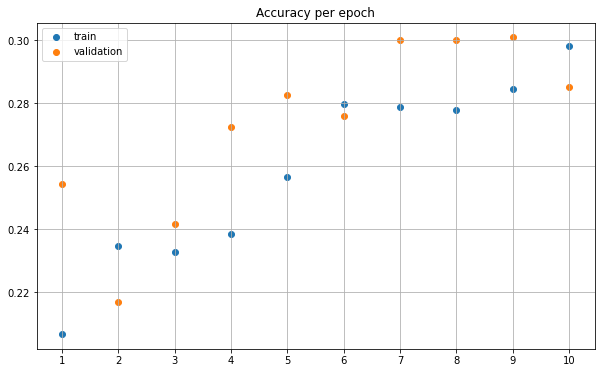

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x = axis_x, y = epoch_accuracy_train, label = "train")
ax.scatter(x = axis_x, y = epoch_accuracy_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Accuracy per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()

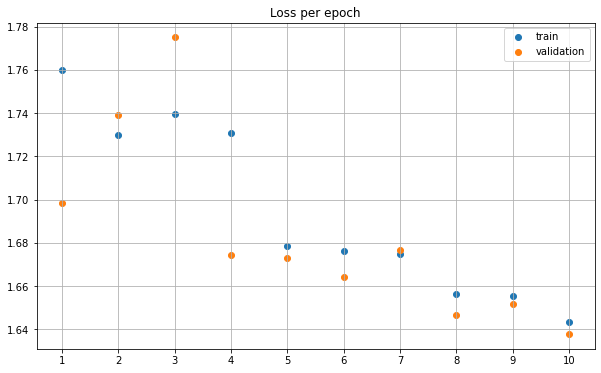

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = axis_x, y = epoch_loss_train, label="train")
ax.scatter(x = axis_x, y = epoch_loss_val, label="validation")
ax.legend()
ax.grid()
ax.set_title("Loss per epoch")
ax.set_xticks(ticks = axis_x)
plt.show()